<div style="display: flex; align-items: center;">
    <img alt="udeA logo" height="140px" src="https://github.com/freddyduitama/images/blob/master/logo.png?raw=true" style="width:107px;height:152px; margin-right: 40px;">
    <div style="text-align: center;">
        <h1><b><font color='0B5345'>Proyecto 3: Filtros</font></b></h1>
        <h2><font color='0B5345'>Proyecto 2024-02</font></h2>
        <h3><font color='0B5345'>Luisa Fernanda Enciso - Jader Stalyn Chingal Atis</font></h3>
    </div>
</div>

In [136]:
import pandas as pd
import scipy.signal as signal
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import random
from scipy.signal import butter, filtfilt
import pywt


In [137]:
import warnings
warnings.filterwarnings('ignore')

<hr>

Extracción de los registros que corresponden a bradicardia sinusal (SB Sinus Bradycardia) y fibrilación auricular (AFIB Atrial Fibrillation). 


In [138]:
# Cargar el archivo Excel en un DataFrame
ruta=r"C:\Users\luisa\OneDrive - Universidad de Antioquia\Documentos\BIOSENALES24II\Proyecto2\Diagnostics.xlsx"
diagnostics_df = pd.read_excel(ruta)

# Crear el nuevo dataframe filtrando por la columna 'Rhythm'
datos = diagnostics_df[(diagnostics_df['Rhythm'] == 'SB') | (diagnostics_df['Rhythm'] == 'AFIB')]

# Discriminar datos de acuerdo a su caracteristica 
datos_SB = diagnostics_df[(diagnostics_df['Rhythm'] == 'SB')]
datos_AFIB = diagnostics_df[(diagnostics_df['Rhythm'] == 'AFIB')]

# Convertir la columna 'FileName' en una lista de Python
datos_lista = datos['FileName'].tolist()

datos_lista_SB = datos_SB['FileName'].tolist()
datos_lista_AFIB = datos_AFIB['FileName'].tolist()

datos.head()

,FileName,Rhythm,Beat,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
0,MUSE_20180113_171327_27000,AFIB,RBBB TWC,85,MALE,117,234,114,356,496,81,-27,19,208,265,386
1,MUSE_20180112_073319_29000,SB,TWC,59,FEMALE,52,52,92,432,401,76,42,8,215,261,431
3,MUSE_20180113_121940_44000,SB,NONE,66,MALE,53,53,96,456,427,34,3,9,219,267,447
5,MUSE_20180112_120347_79000,SB,NONE,46,FEMALE,57,57,70,404,393,38,24,9,225,260,427
6,MUSE_20180114_075026_69000,AFIB,TWC,80,FEMALE,98,86,74,360,459,69,83,17,215,252,395


In [139]:
# Imprimir los tamaños de las listas
print(f"Tamaño total de Datos (SB + AFIB): {len(datos_lista)}")
print(f"Tamaño de (SB): {len(datos_lista_SB)}")
print(f"Tamaño de (AFIB): {len(datos_lista_AFIB)}")

Tamaño total de Datos (SB + AFIB): 5669
Tamaño de (SB): 3889
Tamaño de (AFIB): 1780


<hr>

Escoger 10 señales al azar

In [140]:
# Definir la ruta del archivo donde se guardarán los nombres de archivo seleccionados
archivo_seleccion = r"C:\Users\luisa\OneDrive - Universidad de Antioquia\Documentos\BIOSENALES24II\Proyecto3\seleccion_filename.txt"

# Comprobar si el archivo de selección ya existe
if os.path.exists(archivo_seleccion):
    # Cargar los nombres de archivo previamente guardados
    with open(archivo_seleccion, "r") as f:
        seleccion = f.read().splitlines()
    seleccion_SB = seleccion[:5]
    seleccion_AFIB = seleccion[5:]
else:
    # Si el archivo no existe, realizar una selección aleatoria y guardarla
    seleccion_SB = random.sample(datos_SB['FileName'].tolist(), 5)
    seleccion_AFIB = random.sample(datos_AFIB['FileName'].tolist(), 5)
    
    # Guardar solo los nombres de archivo en el archivo de texto
    with open(archivo_seleccion, "w") as f:
        for filename in seleccion_SB + seleccion_AFIB:
            f.write(f"{filename}\n")

# Imprimir las selecciones
print("Señales seleccionadas de SB:", seleccion_SB)
print("Señales seleccionadas de AFIB:", seleccion_AFIB)

Señales seleccionadas de SB: ['MUSE_20180114_070658_51000', 'MUSE_20180113_122021_63000', 'MUSE_20180113_184550_73000', 'MUSE_20180113_184711_55000', 'MUSE_20180118_180721_94000']
Señales seleccionadas de AFIB: ['MUSE_20180116_121956_37000', 'MUSE_20180115_125217_32000', 'MUSE_20180119_171120_09000', 'MUSE_20180113_135045_85000', 'MUSE_20180113_074547_62000']


<hr>
Consultar que otros tipos de señales wavelet se pueden usar para el análisis de señales ECG y adaptar el código del filtro wavelet que se entrega en el curso de acuerdo a la consulta (10%)

In [141]:
def wnoisest(coeff):
    stdc = np.zeros((len(coeff),1))
    for i in range(0,len(coeff)):
        stdc[i] = (np.median(np.absolute(coeff[i])))/0.6745
    return stdc
def threshold(coeff):
    Num_samples = 0
    for i in range(0,len(coeff)):
        Num_samples = Num_samples + coeff[i].shape[0]

    thr = np.sqrt(2*(np.log(Num_samples)))
    return thr
def wthresh(coeff):
    y   = list()
    s = wnoisest(coeff)
    print(s)
    thr = threshold(coeff)
    print(thr)
    for i in range(0,len(coeff)):
        y.append(np.multiply(coeff[i],np.abs(coeff[i])>(thr*s[i])))
    return thr,s,y

Estas wavelets se organizan en grupos denominados familias de wavelets. Las familias más utilizadas son:

In [ ]:
import pywt
pywt.families()
['haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus', 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor']



['haar',
 'db',
 'sym',
 'coif',
 'bior',
 'rbio',
 'dmey',
 'gaus',
 'mexh',
 'morl',
 'cgau',
 'shan',
 'fbsp',
 'cmor']

In [ ]:
for family in pywt.families():
    print("%s family: " % family + ', '.join(pywt.wavelist(family)))
#La wavelist() función con el nombre de la familia pasado como argumento se utiliza para obtener la lista de nombres de wavelets en cada familia.

haar family: haar
db family: db1, db2, db3, db4, db5, db6, db7, db8, db9, db10, db11, db12, db13, db14, db15, db16, db17, db18, db19, db20, db21, db22, db23, db24, db25, db26, db27, db28, db29, db30, db31, db32, db33, db34, db35, db36, db37, db38
sym family: sym2, sym3, sym4, sym5, sym6, sym7, sym8, sym9, sym10, sym11, sym12, sym13, sym14, sym15, sym16, sym17, sym18, sym19, sym20
coif family: coif1, coif2, coif3, coif4, coif5, coif6, coif7, coif8, coif9, coif10, coif11, coif12, coif13, coif14, coif15, coif16, coif17
bior family: bior1.1, bior1.3, bior1.5, bior2.2, bior2.4, bior2.6, bior2.8, bior3.1, bior3.3, bior3.5, bior3.7, bior3.9, bior4.4, bior5.5, bior6.8
rbio family: rbio1.1, rbio1.3, rbio1.5, rbio2.2, rbio2.4, rbio2.6, rbio2.8, rbio3.1, rbio3.3, rbio3.5, rbio3.7, rbio3.9, rbio4.4, rbio5.5, rbio6.8
dmey family: dmey
gaus family: gaus1, gaus2, gaus3, gaus4, gaus5, gaus6, gaus7, gaus8
mexh family: mexh
morl family: morl
cgau family: cgau1, cgau2, cgau3, cgau4, cgau5, cgau6, cgau7, 

In [16]:
w = pywt.Wavelet('sym4') #objeto wavelet 
print(w) #caracteristicas del tipo de Wavelet

Wavelet sym4
  Family name:    Symlets
  Short name:     sym
  Filters length: 8
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       near symmetric
  DWT:            True
  CWT:            False


In [ ]:
# Función principal: aplica el filtrado wavelet usando 'sym4'
def filtro_wavelet_sym(signal_data, wavelet='sym4', nivel=4):
    # Descomposición en wavelets (discrete wavelet transform) usando 'sym4'
    coeffs = pywt.wavedec(signal_data, wavelet, level=nivel)
    
    # Calcula el umbral usando la mediana de los coeficientes en el último nivel de detalle
    umbral = np.median(np.abs(coeffs[-1])) / 0.6745
    
    # Aplica umbralización suave (soft thresholding) a los coeficientes
    coeffs = [pywt.threshold(c, umbral, mode='soft') for c in coeffs]
    
    # Reconstruye la señal con los coeficientes filtrados
    return pywt.waverec(coeffs, wavelet)
def filtro_wavelet_bior(signal_data, wavelet='bior2.4', nivel=4):
    # Descomposición en wavelets (discrete wavelet transform) usando 'bior2.4'
    coeffs = pywt.wavedec(signal_data, wavelet, level=nivel)
    
    # Calcula el umbral usando la mediana de los coeficientes en el último nivel de detalle
    umbral = np.median(np.abs(coeffs[-1])) / 0.6745
    
    # Aplica umbralización suave (soft thresholding) a los coeficientes
    coeffs = [pywt.threshold(c, umbral, mode='soft') for c in coeffs]
    
    # Reconstruye la señal con los coeficientes filtrados
    return pywt.waverec(coeffs, wavelet)

Las familias de wavelets se clasifican en varias categorías, cada una con características particulares. Las **Daubechies** son wavelets compactas que se utilizan para compresión y eliminación de ruido. Las **Symlets** son variantes simétricas de las Daubechies, diseñadas para reducir la distorsión en la reconstrucción. Las wavelets **bi-ortogonales** permiten una separación entre las funciones de análisis y síntesis, siendo útiles en el procesamiento de señales. Las wavelets **Haar** son simples y rápidas, ideales para aplicaciones que requieren rapidez, mientras que las **Mexican Hat** son efectivas para detectar características específicas en señales, como picos.[1]

Para el análisis de señales de ECG (electrocardiograma), se utilizan diversas wavelets que facilitan la detección de detalles específicos, como las ondas P, QRS y T. Las más comunes son las wavelets de Daubechies, especialmente Daubechies-4 y Daubechies-6, que son efectivas para la detección de picos y la eliminación de ruido. Las wavelets Symlet ofrecen mejor simetría, reduciendo la distorsión en las señales. Por otro lado, las wavelets bi-ortogonales son útiles para la extracción de características, mientras que las de tipo Mexican Hat y Morlet son populares para detectar eventos transitorios de alta frecuencia. Estas wavelets mejoran la representación de los componentes esenciales del ECG, lo que contribuye a identificar irregularidades cardíacas con mayor precisión.[2]

En el código anterior, se define una función que permite aplicar el filtrado utilizando diferentes tipos de wavelets, como sym4 y bior2.4. La única diferencia entre ambas versiones es el argumento que especifica el tipo de wavelet. La lógica subyacente para el filtrado y la umbralización permanece inalterada, ya que es independiente del tipo específico de wavelet utilizado. Esto se debe a que todos los tipos de wavelets siguen el mismo proceso matemático de descomposición mediante la transformada wavelet discreta (DWT). Es decir, independientemente de si se trata de una wavelet simétrica como sym4 o una biortogonal como bior2.4, el proceso general de descomposición, umbralización y reconstrucción es el mismo. Por lo tanto, el filtrado se aplica de manera consistente, independientemente del tipo de wavelet seleccionado, garantizando así que el procedimiento funcione correctamente para distintas familias de wavelets.



<hr>
<h1>Flujo 1</h1>

1. Filtro pasa-altas usando filtro IIR a 0.5 Hz. Justificar la elección de parámetros y si se usa FIR o IIR
2. Filtro wavelet modificado del punto 3
3. Filtrado pasabajas 50 Hz. Justificar la elección de parámetros y si se usa FIR o IIR

In [142]:
# Definición de los filtros
def filtro_pasa_altas(signal_data, fs, cutoff=0.5, order=4):
    nyquist = 0.5 * fs
    wn_h = cutoff / nyquist  # Frecuencia de corte normalizada
    b_high, a_high = signal.iirfilter(order, wn_h, btype='high', analog=False, ftype='butter')
    return signal.filtfilt(b_high, a_high, signal_data)

def filtro_wavelet(signal_data, wavelet='db4', nivel=4):
    coeffs = pywt.wavedec(signal_data, wavelet, level=nivel)
    umbral = np.median(np.abs(coeffs[-1])) / 0.6745
    coeffs = [pywt.threshold(c, umbral, mode='soft') for c in coeffs]
    return pywt.waverec(coeffs, wavelet)

def filtro_pasa_bajas(signal_data, fs, cutoff=50, order=30):
    nyquist = 0.5 * fs
    wn = cutoff / nyquist  # Frecuencia de corte normalizada
    lowpass = signal.firwin(order + 1, wn, pass_zero='lowpass', window='hamming')  # Filtro FIR
    return signal.filtfilt(b=lowpass, a=1, x=signal_data)  # Aplicación del filtro


In [143]:
# Definición de la función para procesar y graficar las señales
def procesar_flujo1(seleccion, ruta_senales, ruta_senales_prefiltradas, columnas, fs):
    señales_procesadas = []  # Lista para almacenar las señales procesadas
    
    for nombre_archivo in seleccion:
        ruta_archivo = os.path.join(ruta_senales, nombre_archivo + ".csv")  # Ajustar extensión si es necesario
        ruta_archivo_prefiltrado = os.path.join(ruta_senales_prefiltradas, nombre_archivo + ".csv")

        # Cargar la señal desde el archivo original
        if os.path.exists(ruta_archivo) and os.path.exists(ruta_archivo_prefiltrado):
            # Leer el archivo y asignar los nombres de columnas directamente
            df = pd.read_csv(ruta_archivo, delimiter=',', names=columnas, header=0)
            signal = df['II'].to_numpy()  # Almacenar como un array de numpy

            # Leer el archivo de la señal prefiltrada y extraer la derivación 'II'
            df_prefiltrado = pd.read_csv(ruta_archivo_prefiltrado, delimiter=',', names=columnas, header=0)
            signal_prefiltrado = df_prefiltrado['II'].to_numpy()   # Usar solo la columna de la derivación II

            # Filtrar la señal en el orden especificado
            signal_filtro_pasa_altas = filtro_pasa_altas(signal, fs)
            signal_filtro_wavelet = filtro_wavelet(signal_filtro_pasa_altas)
            signal_filtro_pasa_bajas = filtro_pasa_bajas(signal_filtro_wavelet, fs)

            # Almacenar la señal procesada en la lista
            señales_procesadas.append(signal_filtro_pasa_bajas)

            # Graficar señal prefiltrada, señal original y señal procesada
            plt.figure(figsize=(12, 8))
            
            # Graficar la señal original
            plt.subplot(3, 1, 1)
            plt.plot(signal, label='Señal Original - Derivación II')
            plt.title(f'Señal Original - {nombre_archivo}')
            plt.xlabel('Muestras')
            plt.ylabel('Amplitud')
            plt.legend()

            # Graficar la señal prefiltrada
            plt.subplot(3, 1, 2)
            plt.plot(signal_prefiltrado, label='Señal Prefiltrada - Derivación II', color='purple')
            plt.title(f'Señal Prefiltrada - {nombre_archivo}')
            plt.xlabel('Muestras')
            plt.ylabel('Amplitud')
            plt.legend()

            # Graficar la señal procesada
            plt.subplot(3, 1, 3)
            plt.plot(signal_filtro_pasa_bajas, label='Señal Procesada', color='orange')
            plt.title(f'Señal Procesada - {nombre_archivo}')
            plt.xlabel('Muestras')
            plt.ylabel('Amplitud')
            plt.legend()

            plt.tight_layout()
            plt.show()
        else:
            print(f"El archivo {ruta_archivo} o {ruta_archivo_prefiltrado} no existe. Verifica la ruta y el nombre del archivo.")

    return señales_procesadas  # Retornar la lista de señales procesadas


In [144]:
# Ruta donde están almacenados los archivos .csv
ruta_senales = r"C:\Users\luisa\Downloads\ECGData\ECGData"
ruta_senales_prefiltradas = r"C:\Users\luisa\Downloads\ECGDataDenoised\ECGDataDenoised"
archivo_seleccion = r"C:\Users\luisa\OneDrive - Universidad de Antioquia\Documentos\BIOSENALES24II\Proyecto3\seleccion_filename.txt"

# Nombres de las columnas esperadas en los archivos CSV
columnas = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

# Configuración de la frecuencia de muestreo
fs = 500  # Frecuencia de muestreo en Hz 

<hr>

**Flujo 1 - Sujetos con SB**

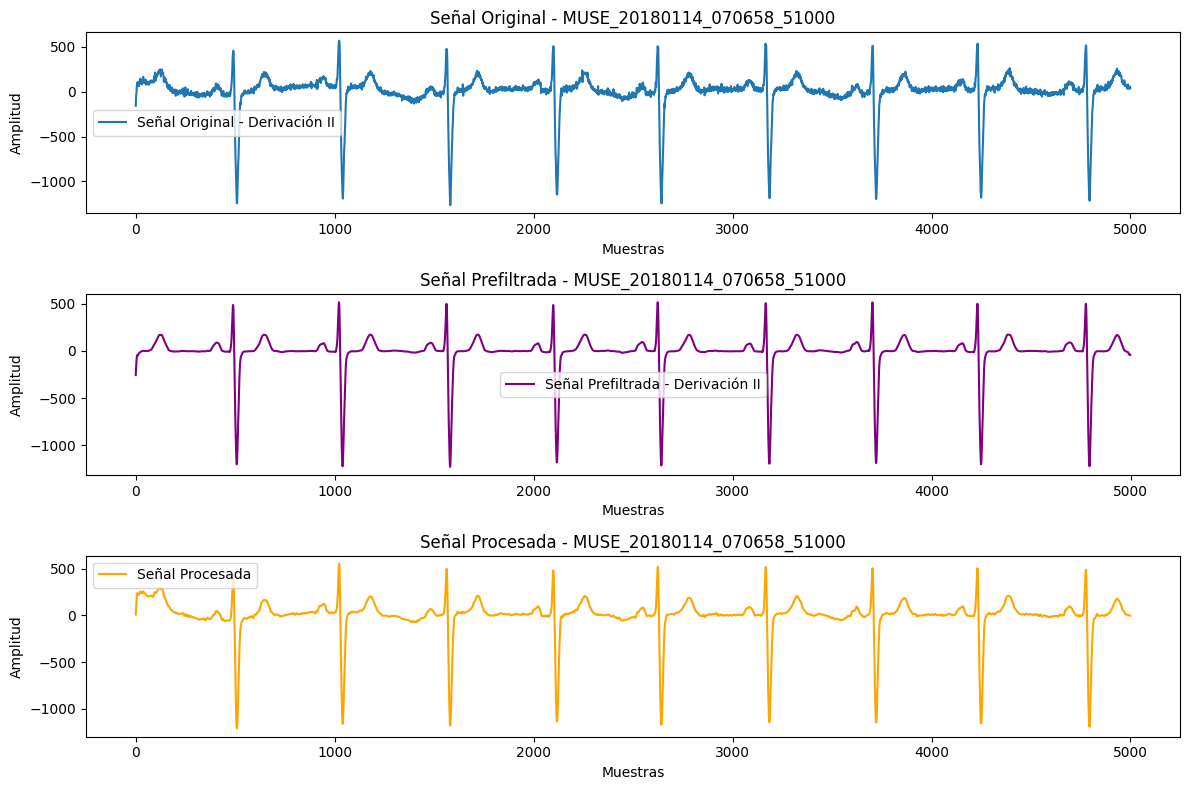

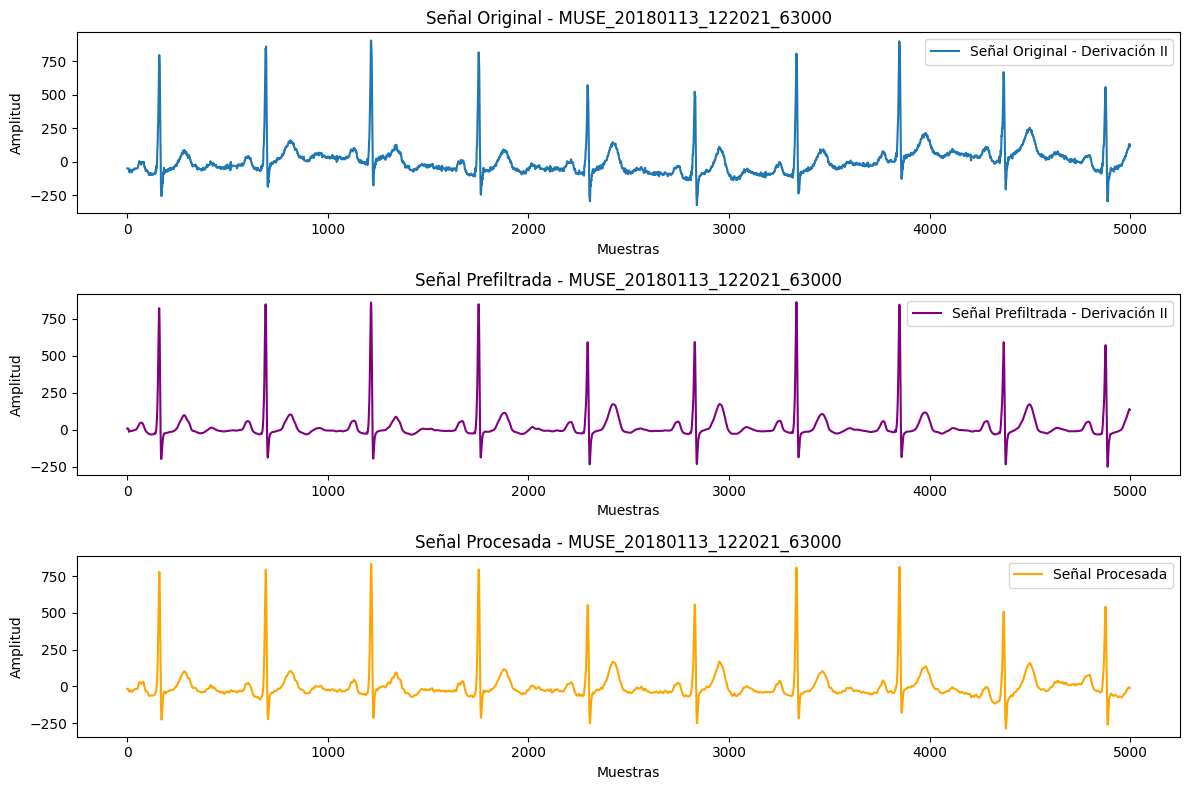

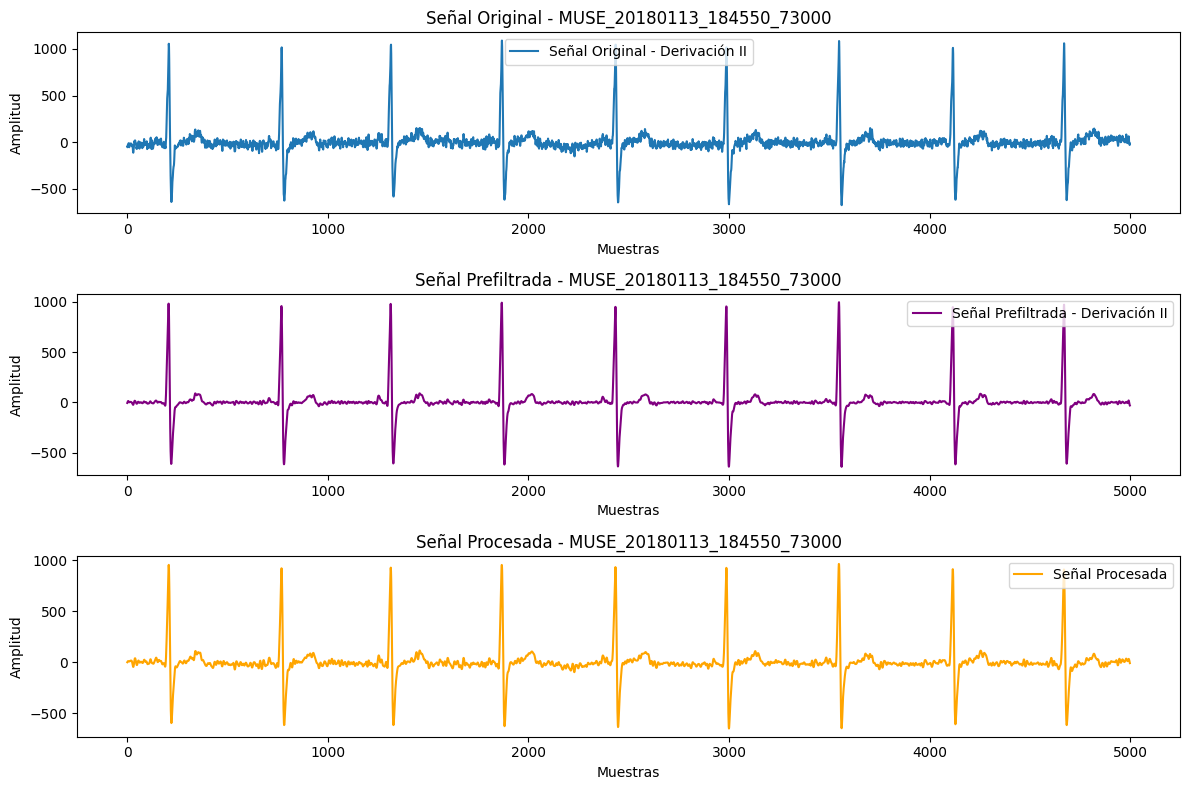

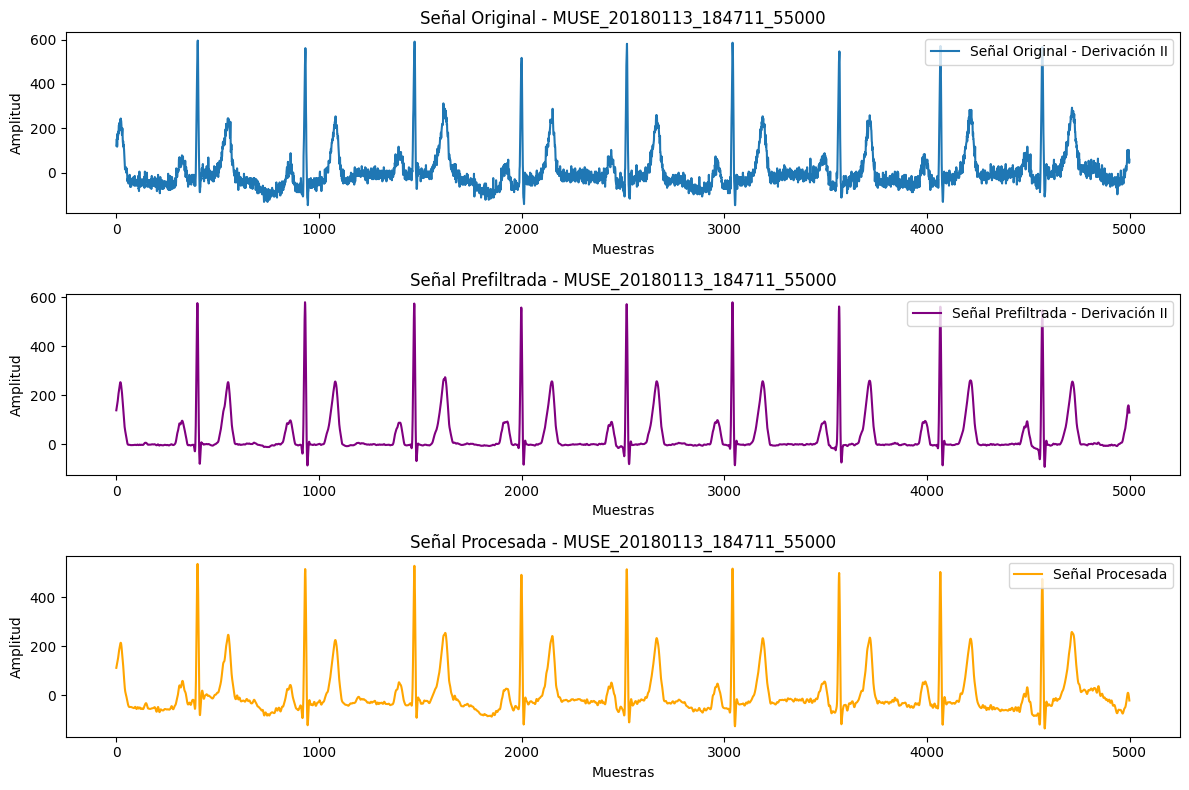

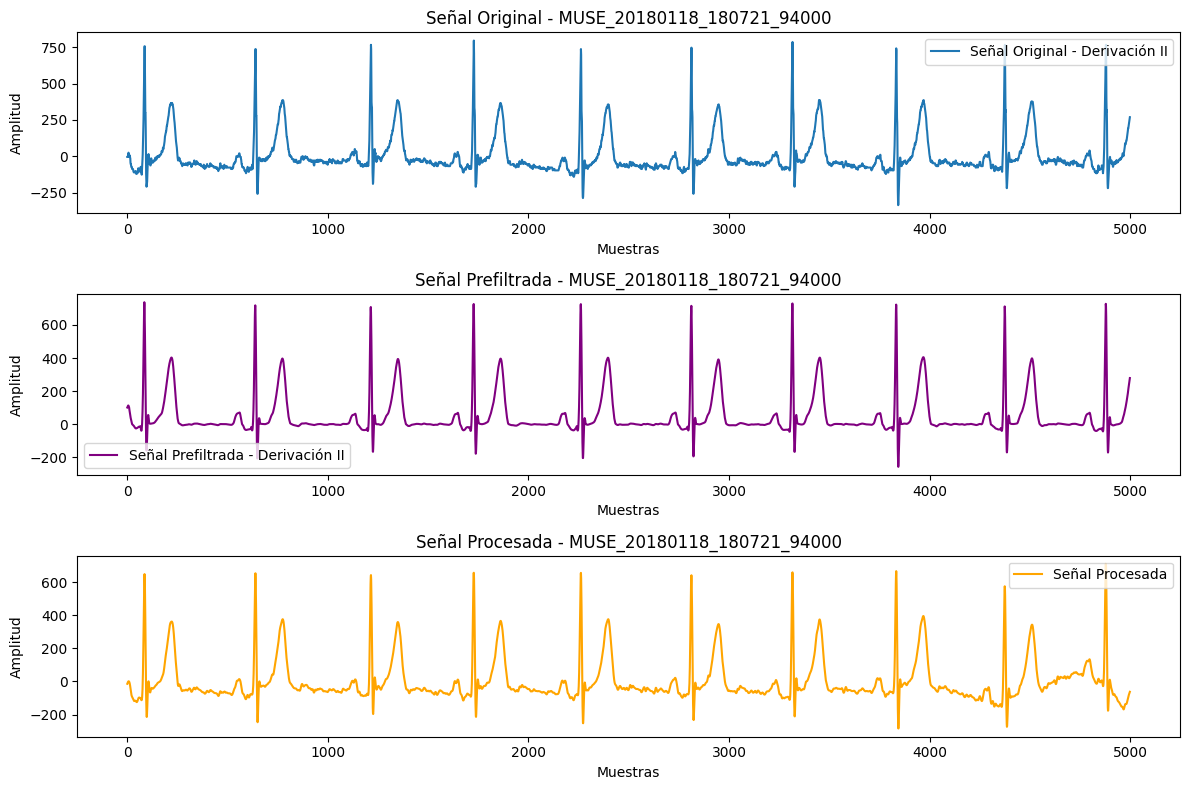

In [145]:
# Uso de la función para procesar señales de SB
SB_Flujo1 = procesar_flujo1(seleccion_SB, ruta_senales, ruta_senales_prefiltradas, columnas, fs)


<hr>

**Flujo 1 - Sujetos con AFIB**

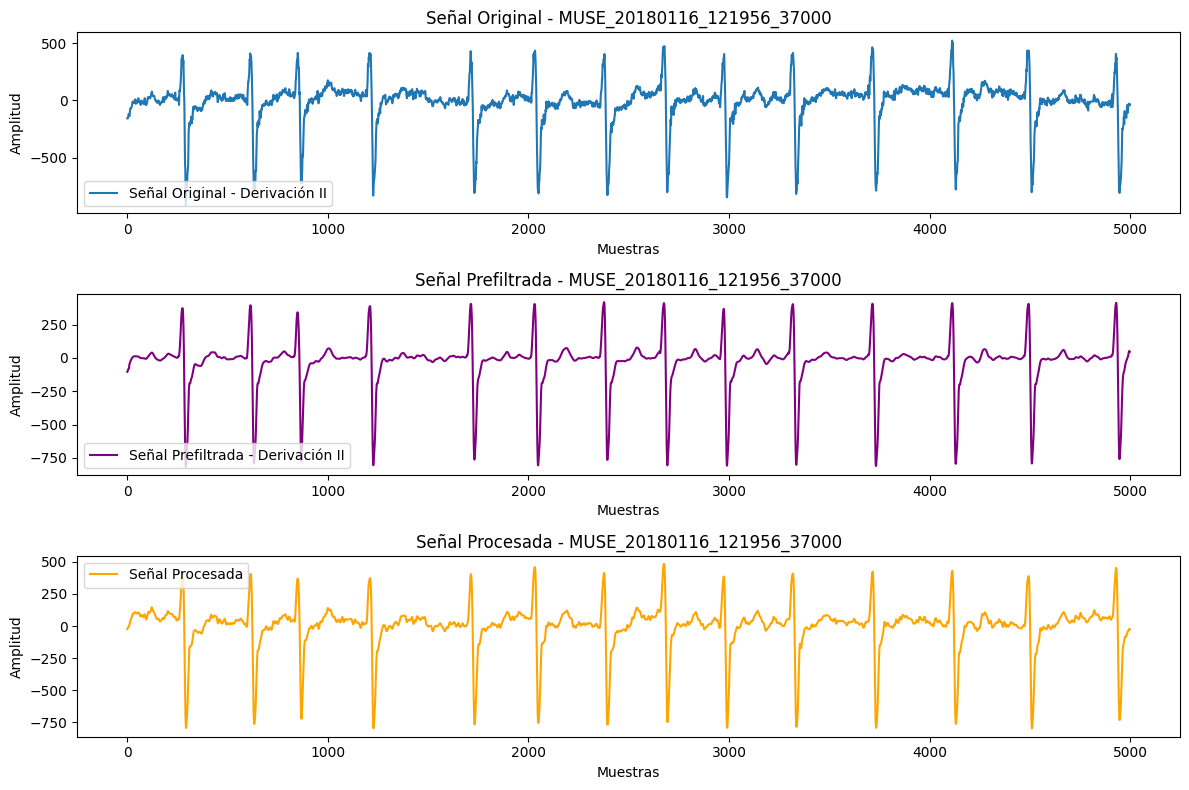

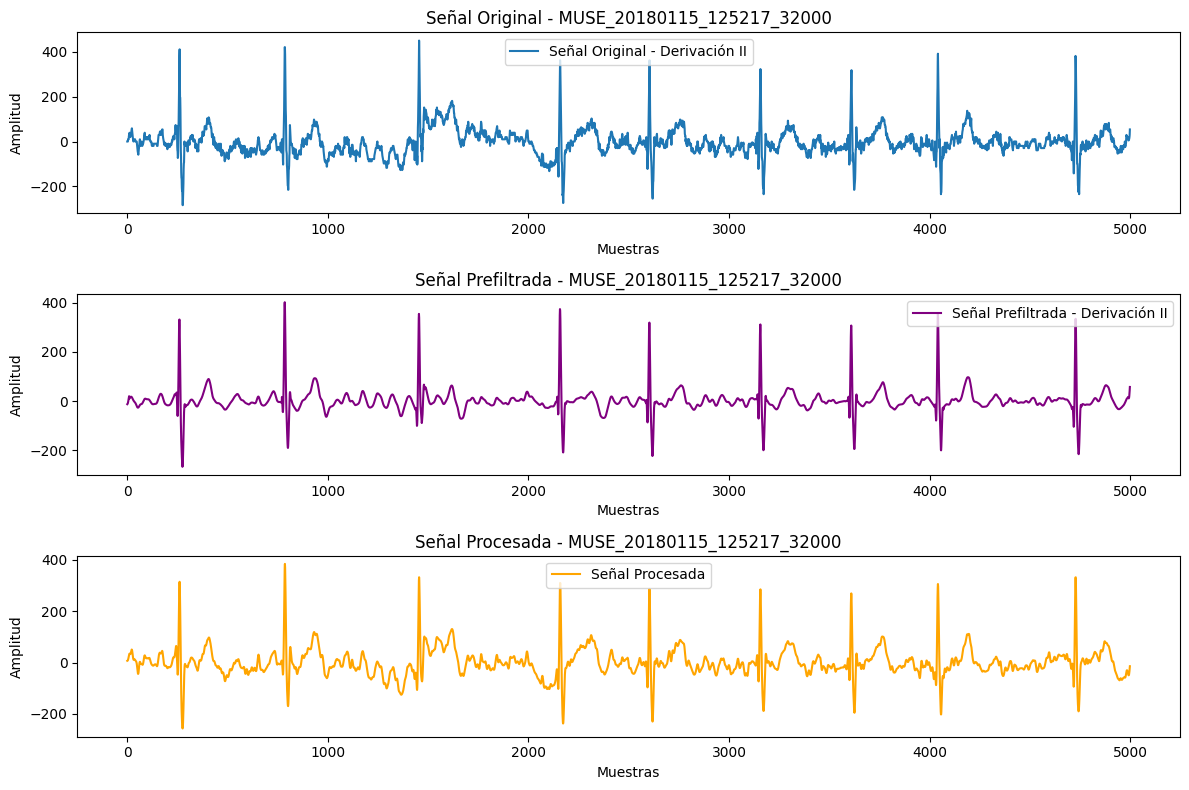

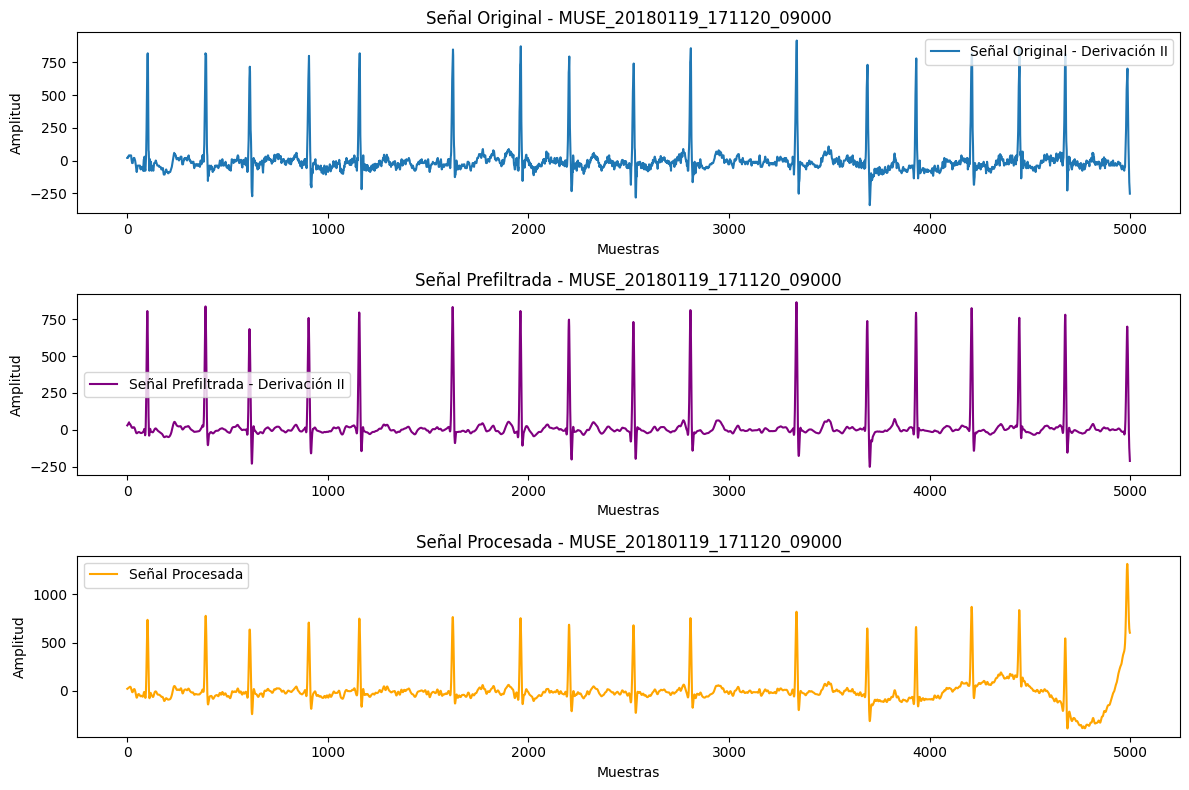

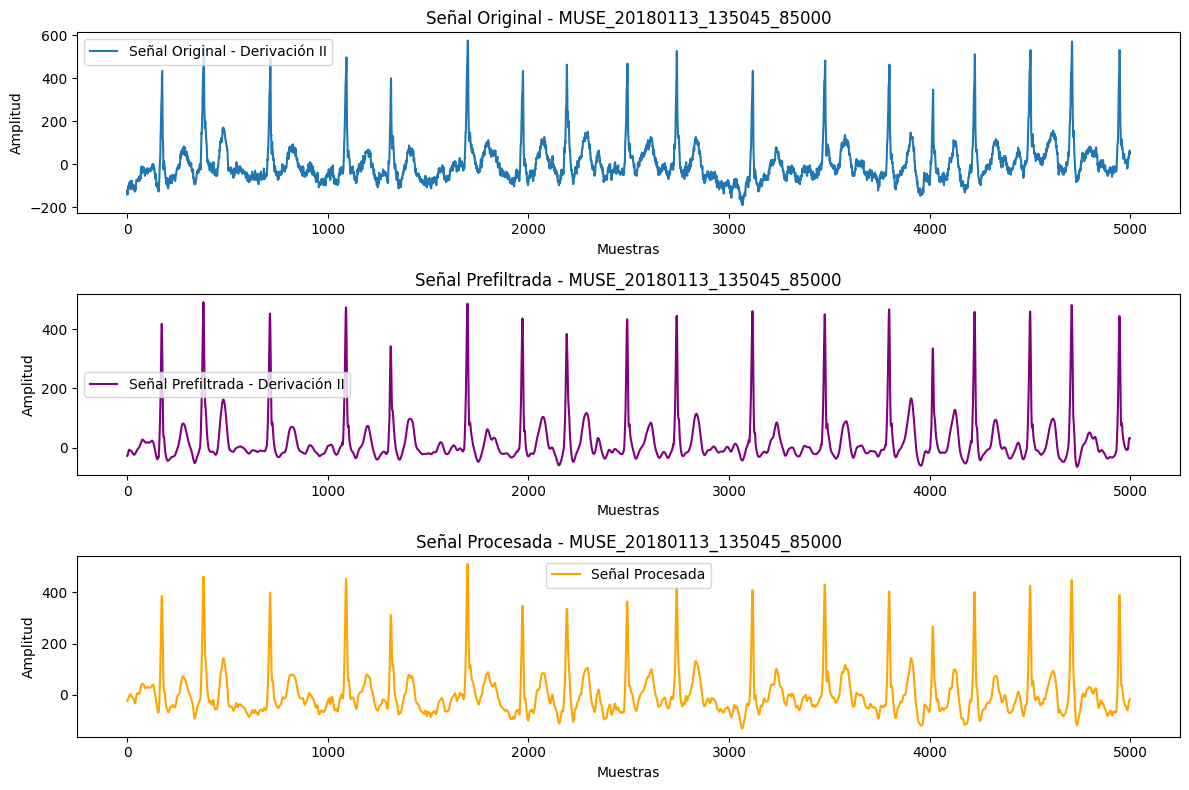

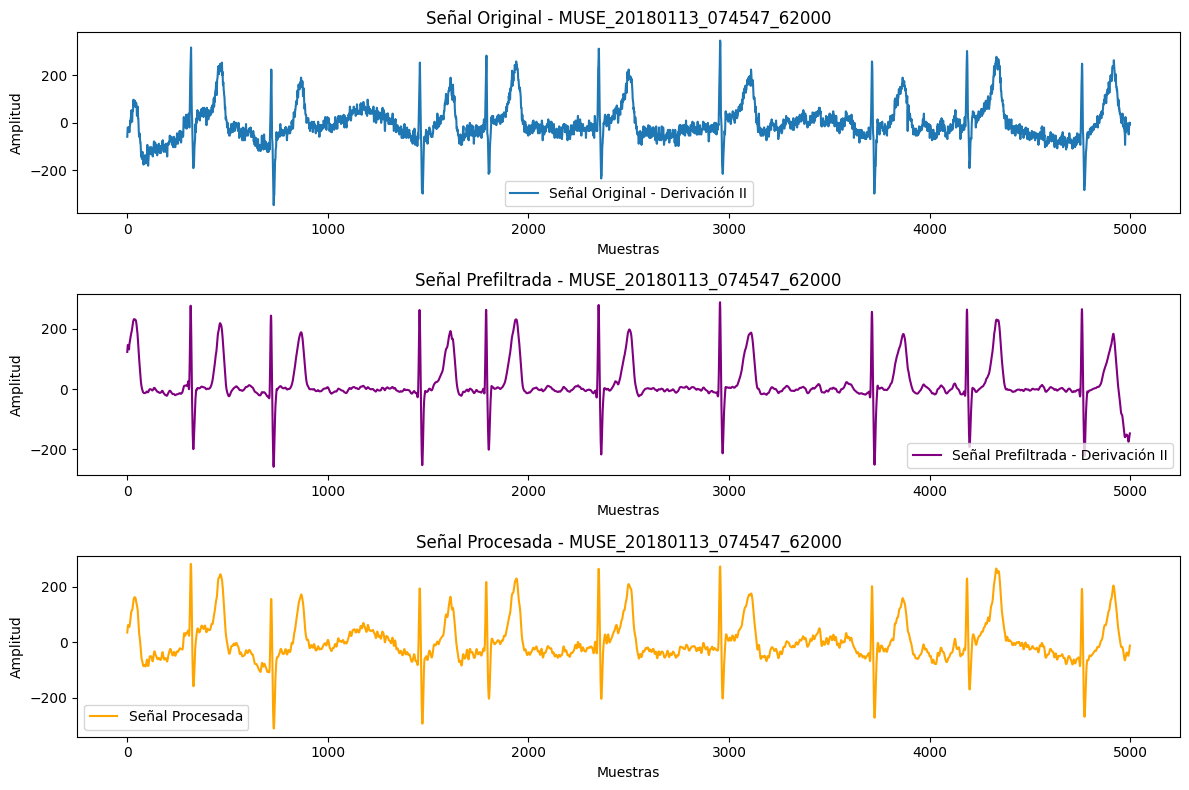

In [146]:
# Uso de la función para procesar señales de AFIB
AFIB_Flujo1 = procesar_flujo1(seleccion_AFIB, ruta_senales, ruta_senales_prefiltradas, columnas, fs)

<hr>
<h1>Flujo 2</h1>

1. Detrend
2. Filtro wavelet modificado del punto 3
3. Filtrado pasabajas 50 Hz. Justificar la elección de parámetros y si se usa FIR o IIR

<hr>
<h1>Flujo 3</h1>

1. Filtro pasa-altas usando filtro IIR a 0.5 Hz. Justificar la elección de parámetros y si se usa FIR o IIR
2. Filtrado pasabajas 50 Hz. Justificar la elección de parámetros y si se usa FIR o IIR

## **Referencias**

[1] Dremin, I. M., Ivanov, O. V., & Nechitailo, V. A. (2001). Wavelets and their uses. Physics-Uspekhi, 44(5), 447. https://iopscience.iop.org/article/10.1070/PU2001v044n05ABEH000918/meta

[2] Li, W. (2018). Wavelets for electrocardiogram: overview and taxonomy. IEEE Access, 7, 25627-25649. https://ieeexplore.ieee.org/abstract/document/8528394